# Detecting Depression from text

## Import Libraries

In [1]:
import numpy as np 
import pandas as pd

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional,GlobalMaxPooling1D,Input,Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.models import Sequential, load_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import nltk
from nltk.corpus import stopwords
import string

from tqdm import tqdm
import seaborn as sns
from wordcloud import WordCloud
import re
import string
import pickle
import warnings
warnings.filterwarnings('ignore')

## Load Data

In [2]:
data = pd.read_csv('./data/depressed_non_depressed_tweets.csv')
data = data.drop("Unnamed: 0", axis=1)

In [3]:
data.head()

,tweet,target
0,Today in Selfcare: beauty &amp; laughs Kung Fu...,0
1,I get to spend New Year's home again alone and...,1
2,"Depressed and lonely /: Stuck in a deep, never...",1
3,If this is your response to someone saying the...,0
4,Apparently you get a free pass just by mention...,0


## EDA

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   tweet   3200 non-null   object
 1   target  3200 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 50.1+ KB


In [5]:
data.describe()

,target
count,3200.000000
mean,0.263437
std,0.440566
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [6]:
data["target"].value_counts()

0    2357
1     843
Name: target, dtype: int64

In [7]:
data.isnull().sum()

tweet     0
target    0
dtype: int64

## Data Cleaning

In [8]:
# Drop Duplicates
data = data.drop_duplicates().reset_index()

In [9]:
data

,index,tweet,target
0,0,Today in Selfcare: beauty &amp; laughs Kung Fu...,0
1,1,I get to spend New Year's home again alone and...,1
2,2,"Depressed and lonely /: Stuck in a deep, never...",1
3,3,If this is your response to someone saying the...,0
4,4,Apparently you get a free pass just by mention...,0
...,...,...,...
3094,3194,Depression is like wearing a one of those weig...,1
3095,3195,"May the new year abound in H’s: Health, Hope, ...",0
3096,3196,It is not a beautiful day as usual.,1
3097,3197,Compact Metal Leaf Grinder with Four Layers p...,0


In [10]:
data.iloc[0]["tweet"]

'Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia'

In [11]:
data["tweet"].values

array(['Today in Selfcare: beauty &amp; laughs Kung Fu Panda 3 #Wellness #joy #laughter #selfcare #therapist #philadelphia',
       "I get to spend New Year's home again alone and lonely. ???• ",
       'Depressed and lonely /: Stuck in a deep, never ending hole :(  ',
       ..., 'It is not a beautiful day as usual.',
       'Compact Metal Leaf Grinder with Four Layers  pic.twitter.com/VTan3PBT6H',
       "First Christmas in YEARS that I have to work.  it just doesn't feel the same."],
      dtype=object)

## Data Preprocessing Pipeline

In [12]:
# Tweets cleaning

def remove_hashtags_mentions(sent):
    removed_mentions = re.sub("@[A-Za-z0-9_]+", "", sent)
    removed_hashtags = re.sub("#[A-Za-z0-9_]+","", removed_mentions)
    return removed_hashtags

In [13]:
# lowercase
def lower_case(sent):
    return sent.lower()

In [14]:
# Removing Punctuation
def remove_punctuation(sent):
    return " ".join([char for char in sent.split() if char not in string.punctuation])

In [15]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [16]:
# Tokenize
def tokenize_sent(sent):
    return nltk.word_tokenize(sent)

In [17]:
# Stopword Filtering
stop_words = stopwords.words('english')
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [18]:
def filter_stopwords(tokens):
    return " ".join([word for word in tokens.split() if word not in stop_words])

In [19]:
# Lemmatization
wordnet_lemmatizer = nltk.WordNetLemmatizer()

In [20]:
def lemmatizer(tokens):
    return " ".join([wordnet_lemmatizer.lemmatize(word) for word in tokens.split()])

In [21]:
def preprocess_pipeline(sentence):
    
    sent = remove_hashtags_mentions(sentence)
    sent = lower_case(sent)
    sent = remove_punctuation(sent)
    
#     sent = filter_stopwords(sent)
    
#     preprocessed_sent = lemmatizer(sent)
    if sent is float:
        return None
    
    return sent

In [22]:
# small test
print(preprocess_pipeline(data.iloc[0]["tweet"]))

today in selfcare: beauty &amp; laughs kung fu panda 3


### Preprocess the Data

In [23]:
data["preprocessed text"] = data["tweet"].apply(preprocess_pipeline)

In [24]:
data.head()

,index,tweet,target,preprocessed text
0,0,Today in Selfcare: beauty &amp; laughs Kung Fu...,0,today in selfcare: beauty &amp; laughs kung fu...
1,1,I get to spend New Year's home again alone and...,1,i get to spend new year's home again alone and...
2,2,"Depressed and lonely /: Stuck in a deep, never...",1,"depressed and lonely stuck in a deep, never en..."
3,3,If this is your response to someone saying the...,0,if this is your response to someone saying the...
4,4,Apparently you get a free pass just by mention...,0,apparently you get a free pass just by mention...


In [25]:
data.to_csv("./data/preprocessed_depression_messages.csv", index=False)

In [26]:
data = pd.read_csv("./data/preprocessed_depression_messages.csv")[["tweet", "target", "preprocessed text"]]

In [27]:
data

,tweet,target,preprocessed text
0,Today in Selfcare: beauty &amp; laughs Kung Fu...,0,today in selfcare: beauty &amp; laughs kung fu...
1,I get to spend New Year's home again alone and...,1,i get to spend new year's home again alone and...
2,"Depressed and lonely /: Stuck in a deep, never...",1,"depressed and lonely stuck in a deep, never en..."
3,If this is your response to someone saying the...,0,if this is your response to someone saying the...
4,Apparently you get a free pass just by mention...,0,apparently you get a free pass just by mention...
...,...,...,...
3094,Depression is like wearing a one of those weig...,1,depression is like wearing a one of those weig...
3095,"May the new year abound in H’s: Health, Hope, ...",0,"may the new year abound in h’s: health, hope, ..."
3096,It is not a beautiful day as usual.,1,it is not a beautiful day as usual.
3097,Compact Metal Leaf Grinder with Four Layers p...,0,compact metal leaf grinder with four layers pi...


## Building Tokenizer

In [28]:
data["preprocessed text"].values

array(['today in selfcare: beauty &amp; laughs kung fu panda 3',
       "i get to spend new year's home again alone and lonely. ???•",
       'depressed and lonely stuck in a deep, never ending hole :(', ...,
       'it is not a beautiful day as usual.',
       'compact metal leaf grinder with four layers pic.twitter.com/vtan3pbt6h',
       "first christmas in years that i have to work. it just doesn't feel the same."],
      dtype=object)

In [29]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data["tweet"].values)

word_index = tokenizer.word_index
vocab_size=len(word_index)

In [30]:
with open("./API/depression_tokenizer.obj", "wb") as f :
    pickle.dump(tokenizer, f)

In [31]:
embedding_dim = 300
max_length = 350
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [32]:
sequences = tokenizer.texts_to_sequences(data["tweet"].values)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## Train Test Split

In [33]:
from sklearn.model_selection import train_test_split

In [34]:
X_train, X_test, y_train, y_test = train_test_split(padded, data["target"], test_size=0.3, stratify=data["target"])

In [35]:
len(X_train), len(X_test), len(y_train), len(y_test)

(2169, 930, 2169, 930)

In [36]:
X_train = np.array(X_train).astype('float32')
X_test = np.array(X_test).astype('float32')
y_train = np.array(y_train).astype('float32')
y_test = np.array(y_test).astype('float32')

In [37]:
X_train[0].shape

(350,)

## Encode Data

In [40]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [41]:
encoder = list(le.classes_)
encoder

[0.0, 1.0]

## Load Glove Embedding

In [42]:
# 300 dimension version of GloVe from Stanford

embeddings_index = {};
with open('./pre_trained_Embedding/glove.6B/glove.6B.300d.txt', encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [43]:
print(len(embeddings_matrix))

8536


## Building the AI Model I - Bi - LSTM

In [86]:
def get_model():

    model = tf.keras.Sequential()
    model.add(Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False))
    model.add(Bidirectional(tf.keras.layers.LSTM(32)))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(16, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [87]:
model = get_model()

In [88]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 350, 300)          2560800   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               85248     
 nal)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                      

## Training the AI model

In [89]:
callback = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5),
            tf.keras.callbacks.ModelCheckpoint(
              filepath='./models/depression_pred_model.h5',
              save_weights_only=False,
              monitor='val_loss',
              save_best_only=True),
            ]

In [90]:
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_test, y_test),callbacks = [callback])

Epoch 1/20
68/68 [==============================] - 5s 50ms/step - loss: 0.6441 - accuracy: 0.6846 - val_loss: 0.5778 - val_accuracy: 0.7280
Epoch 2/20
68/68 [==============================] - 3s 38ms/step - loss: 0.5652 - accuracy: 0.7284 - val_loss: 0.5255 - val_accuracy: 0.7280
Epoch 3/20
68/68 [==============================] - 3s 39ms/step - loss: 0.5067 - accuracy: 0.7344 - val_loss: 0.4813 - val_accuracy: 0.7559
Epoch 4/20
68/68 [==============================] - 3s 40ms/step - loss: 0.4731 - accuracy: 0.7529 - val_loss: 0.4655 - val_accuracy: 0.7602
Epoch 5/20
68/68 [==============================] - 3s 39ms/step - loss: 0.4320 - accuracy: 0.7612 - val_loss: 0.4713 - val_accuracy: 0.7710
Epoch 6/20
68/68 [==============================] - 3s 40ms/step - loss: 0.4063 - accuracy: 0.7967 - val_loss: 0.4776 - val_accuracy: 0.7849
Epoch 7/20
68/68 [==============================] - 3s 39ms/step - loss: 0.3667 - accuracy: 0.8248 - val_loss: 0.4575 - val_accuracy: 0.7667
Epoch 8/20
68

In [111]:
model = load_model("./models/depression_pred_model.h5")

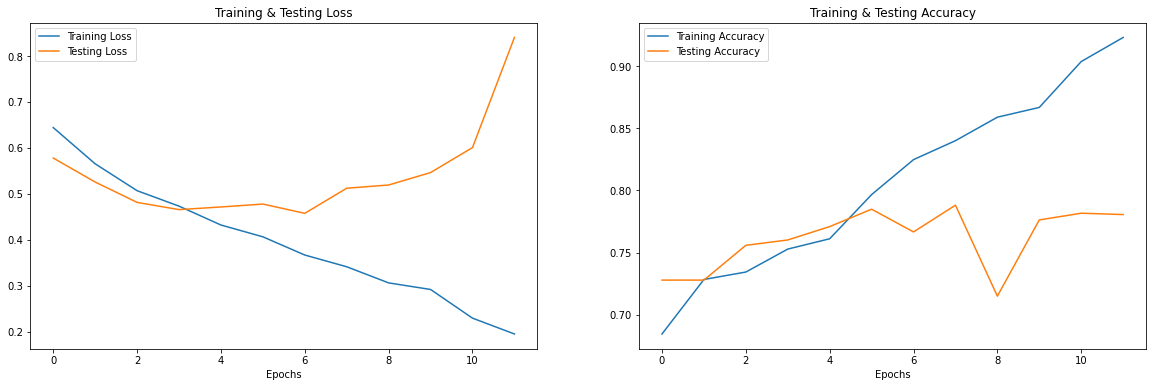

In [92]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Testing Loss')
ax[0].set_title('Training & Testing Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Testing Accuracy')
ax[1].set_title('Training & Testing Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

In [93]:
model.evaluate(X_test, y_test)

30/30 [==============================] - 1s 24ms/step - loss: 0.4575 - accuracy: 0.7667


[0.45747053623199463, 0.7666666507720947]

In [94]:
pred = model.predict(X_test)

In [95]:
preds = [1 if x> 0.5 else 0 for x in pred]

In [96]:
precision_score(preds, y_test, average="macro")

0.7320514242677238

In [97]:
recall_score(preds, y_test, average="macro")

0.711793418023702

In [98]:
f1_score(preds, y_test, average="macro")

0.7196066907587335

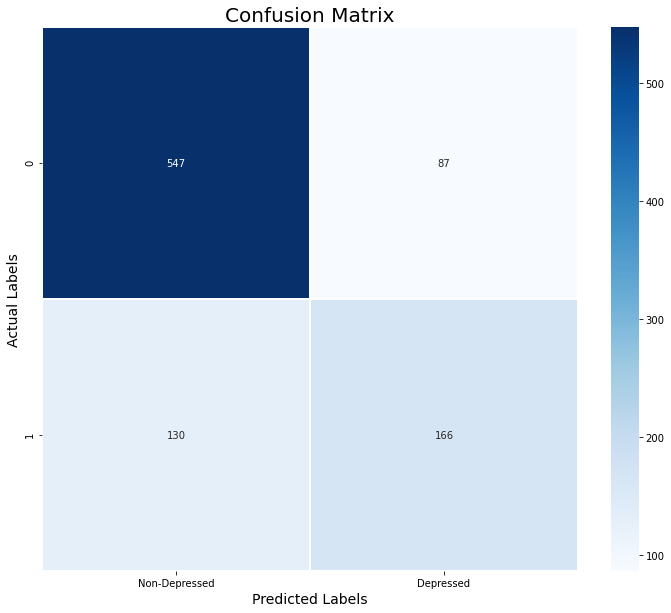

In [99]:
cm = confusion_matrix(preds, y_test)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , columns = ["Non-Depressed","Depressed"])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()

In [100]:
print(classification_report(preds, y_test, target_names=["Non-Depressed","Depressed"]))

               precision    recall  f1-score   support

Non-Depressed       0.81      0.86      0.83       634
    Depressed       0.66      0.56      0.60       296

     accuracy                           0.77       930
    macro avg       0.73      0.71      0.72       930
 weighted avg       0.76      0.77      0.76       930



In [101]:
# Tweets cleaning

def remove_hashtags_mentions(sent):
    removed_mentions = re.sub("@[A-Za-z0-9_]+", "", sent)
    removed_hashtags = re.sub("#[A-Za-z0-9_]+","", removed_mentions)
    return removed_hashtags

In [102]:
# lowercase
def lower_case(sent):
    return sent.lower()

In [103]:
# Removing Punctuation
def remove_punctuation(sent):
    return " ".join([char for char in sent.split() if char not in string.punctuation])

In [104]:
def clean_pipeline(sentence):
    
    sent = remove_hashtags_mentions(sentence)
    sent = lower_case(sent)
    sent = remove_punctuation(sent)

    if sent is float:
        return None
    
    return sent

In [105]:
embedding_dim = 300
max_length = 350
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [106]:
# model = load_model("./API/depression_pred_model.h5")

In [112]:
def depression_pipeline(text):
    if type(text) is str:
        p_text = clean_pipeline(text)
        sequences = tokenizer.texts_to_sequences([p_text])
    else:
        p_text = [clean_pipeline(x) for x in text]
        sequences = tokenizer.texts_to_sequences(p_text)
        
    padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
    padded = np.array(padded)
    
    pred = model.predict(padded)
    emotion = ["Depressed" if x > 0.5 else "Not Depressed"  for x in pred]
    percentage = [x[0] * 100 for x in pred]

    return list(zip(emotion, percentage))

In [113]:
depression_pipeline(["I wanna jump off a cliff", "Dieee"])

[('Not Depressed', 38.804274797439575), ('Not Depressed', 4.955104365944862)]

In [114]:
import json

In [115]:
json.dumps(depression_pipeline(["I wanna jump off a cliff", "Dieee"]))

'[["Not Depressed", 38.804274797439575], ["Not Depressed", 4.955104365944862]]'